In [4]:
import pandas as pd # Pour le dataframe
import numpy as np # Pour la normalisation et calculs de moyenne
import matplotlib.pyplot as plt # Pour la visualisation

from PIL import Image

import librosa # Pour l'extraction des features et la lecture des fichiers wav
import librosa.display # Pour récupérer les spectrogrammes des audio
import librosa.feature

import os # C'est ce qui va nous permettre d'itérer sur les fichiers de l'environnement de travail

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV # Split de dataset et optimisation des hyperparamètres
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.ensemble import GradientBoostingClassifier # XGBoost
from sklearn.neighbors import KNeighborsClassifier # k-NN
from sklearn.svm import SVC # SVM
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report # Métriques pour la mesure de performances
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf # Pour le reseau de neurones simple et pour le CNN

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier
from pprint import pprint

2023-08-08 10:46:16.746115: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 10:46:16.748066: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 10:46:16.784619: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 10:46:16.785493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 10:46:17.837266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
# Définissons la liste avec les genres :

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

# Création d'un dictionnaire avec les genres vide :
audio_files = {}


for g in genres:
  audio_files[g] = []

# Remplissage du dictionnaire en important les fichiers audio avec Librosa :
for g in genres:
  for audio in os.listdir(f'./dataset/genres_original/{g}'):
    audio_files[g].append(librosa.load(f'./dataset/genres_original/{g}/{audio}')[0])

In [6]:
def audio_pipeline(audio):
  features = []

  # Calcul du ZCR

  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

  spectral_centroids = librosa.feature.spectral_centroid(y=audio)[0]
  features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

  rolloff = librosa.feature.spectral_rolloff(y=audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCC

  mfcc = librosa.feature.mfcc(y=audio)

  for x in mfcc:
    features.append(np.mean(x))


  return features

In [8]:
# Définissons les noms des colonnes

column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']

# Création d'un dataframe vide

df = pd.DataFrame(columns = column_names)

# On itère sur les audios pour remplir le dataframe
i = 0
for g in genres:
  for music in audio_files[g]:
    df.loc[i] = audio_pipeline(music)+[g]
    i+=1
    
df.to_csv('./music.csv', index = False)
selector = VarianceThreshold(threshold=(0.2))

selected_features = selector.fit_transform(df[['zcr', 'spectral_c', 'rolloff', 
                                                    'mfcc1', 'mfcc2', 'mfcc3',
                                                    'mfcc4','mfcc5', 'mfcc6', 
                                                    'mfcc7', 'mfcc8', 'mfcc9',
                                                    'mfcc10','mfcc11', 'mfcc12',
                                                    'mfcc13', 'mfcc14', 'mfcc15',
                                                    'mfcc16', 'mfcc17', 'mfcc18', 
                                                    'mfcc19', 'mfcc20']])

pd.DataFrame(selected_features)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,65186.0,2159.398277,4684.512534,-133.048981,105.738907,-22.158222,41.830692,-26.992498,19.118570,-26.566029,...,-10.814380,6.798669,-11.726956,4.397709,-6.031961,1.963063,-12.314546,3.256974,-8.806516,-3.369112
1,37202.0,1537.491387,3495.331816,-252.481781,104.945160,15.296445,42.687840,6.770454,21.611765,-1.311177,...,-1.961952,1.960265,-0.898227,7.762361,2.375863,1.779114,1.330541,3.615051,4.906600,-2.661052
2,57782.0,2155.845202,5011.532444,-109.140709,100.619659,-8.666454,47.354729,-6.568464,39.617756,-8.521923,...,-24.213415,6.583019,-8.652447,4.930261,-15.440971,1.534257,-6.754526,1.415189,-3.971741,3.287160
3,67763.0,2390.421814,5403.593286,-107.203255,88.492897,-4.171899,55.477848,-8.017713,38.413597,-6.413661,...,-19.248566,12.076122,-4.582267,3.784239,-16.988953,11.621647,-7.361444,-3.665254,-7.176823,1.973181
4,42435.0,1719.463366,3782.441191,-121.389793,122.498329,-14.734727,46.122139,-8.179257,20.172466,-19.171892,...,-6.722797,6.989505,-12.730549,5.058538,-5.185806,-1.453605,-7.042629,2.694212,3.409532,-2.713745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,85550.0,2294.229735,4730.226875,-95.257660,103.813416,-37.013618,52.685883,-20.752981,27.573769,-17.526501,...,-9.246779,10.183925,-8.784138,1.838299,-3.953086,2.171482,-6.697739,5.102017,-9.701118,-3.960039
945,104576.0,2510.073143,4735.123056,-47.043789,95.778229,-43.917881,52.071087,-22.550802,20.861921,-18.675611,...,-19.212608,9.452245,-12.584075,3.889403,-8.495848,6.268981,-9.121950,2.689798,-2.442532,-1.879326
946,91196.0,2568.395446,5364.140727,-203.344940,85.411697,-11.576986,54.754364,-11.617431,20.568466,-27.760782,...,-11.927793,4.132144,-3.998545,1.736056,-7.907963,4.303378,-11.239040,-1.184892,-5.032738,-2.364001
947,56499.0,1646.635926,3184.299435,-93.358856,137.467468,-45.092060,37.811539,-9.419834,12.594670,-7.480642,...,-2.459423,-9.579354,-3.167917,-5.562455,-7.494168,-5.683578,-2.015053,-3.879438,-6.208956,-8.088406


In [9]:
X = df[['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
           'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
           'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
           'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']]

y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [10]:
features = df
# valeurs à prédire
labels = np.array(features['label'])
# supprime les labels des données
features = features.drop('label', axis = 1)
# sauvegarde le nom de features
feature_list = list(features.columns)
# conversion en numpy array
features = np.array(features)

# séparer les données en training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 0)
print(train_features[0])
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

[ 3.89190000e+04  1.33635460e+03  2.75188674e+03 -2.02821854e+02
  1.45744705e+02 -2.35611420e+01  4.78489265e+01 -1.43534870e+01
  1.64488566e+00 -7.06590939e+00 -1.11282873e+01 -4.60430479e+00
 -3.60932112e+00 -3.79026723e+00  2.04283834e+00  8.47641230e-01
 -2.02438188e+00 -1.03487802e+00 -1.45292687e+00  7.81598985e-01
 -3.95678610e-01 -2.33745933e+00 -2.01373291e+00]
Training Features Shape: (711, 23)
Training Labels Shape: (711,)
Testing Features Shape: (238, 23)
Testing Labels Shape: (238,)


In [11]:
rf = RandomForestClassifier(random_state = 0)
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [12]:
# nombre d'arbres
n_estimators = [500, 1000, 2000, 3000, 4000, 5000]
# profondeur max de l'arbre
max_depth = [20]
max_depth.append(None)
# nombre d'échantillon min nécessaire par noeuds
min_samples_split = [2, 4]#[2]
# nombre d'échantillon min nécessaire par feuilles
min_samples_leaf = [1, 2]#[1]

# création de la grille
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }
pprint(random_grid)

{'max_depth': [20, None],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 4],
 'n_estimators': [500, 1000, 2000, 3000, 4000, 5000]}


In [13]:
# création du modèle
rf = RandomForestClassifier(random_state = 0, max_features = 'sqrt', bootstrap = True)

# random search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# fit le modèle
rf_random.fit(train_features, train_labels)

pd_res = pd.concat([pd.DataFrame(rf_random.cv_results_["params"]),pd.DataFrame(rf_random.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(rf_random.best_params_)
pd_res.head(5)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   3.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   3.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   6.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   6.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   6.9s
[CV] E

,n_estimators,min_samples_split,min_samples_leaf,max_depth,Accuracy
0,5000,2,1,NaN,0.585091
1,4000,2,1,20.0,0.583685
2,2000,2,1,NaN,0.582278
6,4000,4,1,NaN,0.580872
9,4000,4,1,20.0,0.580872


In [54]:
# création du modèle
rf = RandomForestClassifier(n_estimators=6000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

# fit le modèle
rf.fit(train_features, train_labels)

# prédictions
predictions = rf.predict(test_features)

# Zero_one_loss error
errors = zero_one_loss(test_labels, predictions, normalize=False)
print('zero_one_loss error :', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_labels, predictions)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, test_labels))

zero_one_loss error : 92
accuracy_score on test dataset : 0.6134453781512605
              precision    recall  f1-score   support

       blues       0.65      0.68      0.67        19
   classical       0.94      0.94      0.94        16
     country       0.54      0.58      0.56        26
       disco       0.47      0.62      0.54        24
      hiphop       0.48      0.50      0.49        22
        jazz       0.68      0.65      0.67        23
       metal       0.82      0.64      0.72        22
         pop       0.85      0.65      0.73        34
      reggae       0.50      0.52      0.51        27
        rock       0.46      0.48      0.47        25

    accuracy                           0.61       238
   macro avg       0.64      0.63      0.63       238
weighted avg       0.63      0.61      0.62       238



Text(101.44999999999999, 0.5, 'predicted label')

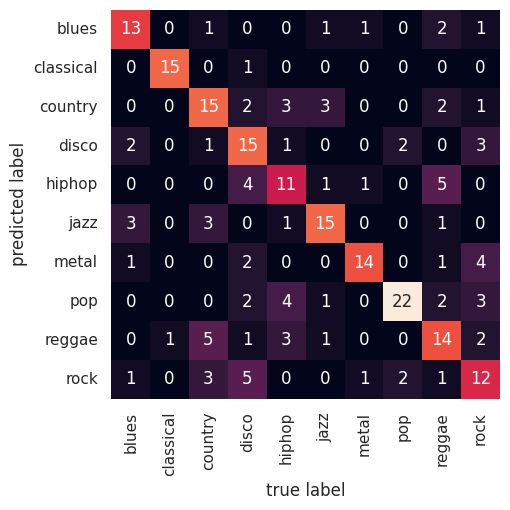

In [55]:
sns.set()
mat = confusion_matrix(test_labels, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=genres, yticklabels=genres)
plt.xlabel('true label')
plt.ylabel('predicted label')

Text(0.5, 1.0, 'Variable Importances')

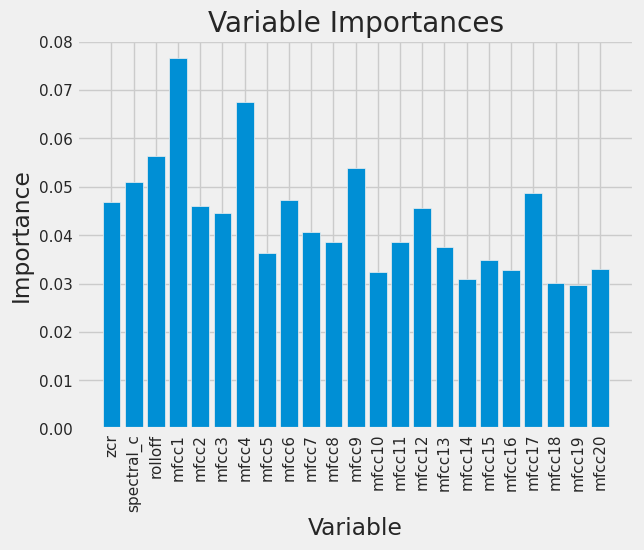

In [16]:
plt.style.use('fivethirtyeight')

importances = list(rf.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

In [53]:
msic = librosa.load(f'./dataset/to_check/sound/classical/classical.00001.wav')[0]
dataf = pd.DataFrame(columns = column_names)
dataf.loc[0] = audio_pipeline(msic)+['']
dataf.to_csv('music1.csv')
print(rf.score)
features = dataf

features = features.drop('label', axis = 1)
features = np.array(features)

# train_features = sc.fit_transform(train_features)
print(features.shape)

pred = rf.predict(features)
print(pred)

<bound method ClassifierMixin.score of RandomForestClassifier(max_depth=20, n_estimators=6000, random_state=0)>
(1, 23)
['metal']
